## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-roberta-base-96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_3.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_4.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_5.tar.gz

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy
fold_2/
fold_2/y_train.npy
fold_2/x_train.npy
fold_2/y_valid.npy
fold_2/x_valid.npy
fold_3/
fold_3/y_train.npy
fold_3/x_train.npy
fold_3/y_valid.npy
fold_3/x_valid.npy
fold_4/
fold_4/y_train.npy
fold_4/x_train.npy
fold_4/y_valid.npy
fold_4/x_valid.npy
fold_5/
fold_5/y_train.npy
fold_5/x_train.npy
fold_5/y_valid.npy
fold_5/x_valid.npy


# Model parameters

In [3]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 6,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 1,
  "question_size": 4,
  "N_FOLDS": 5,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [4]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1e-06


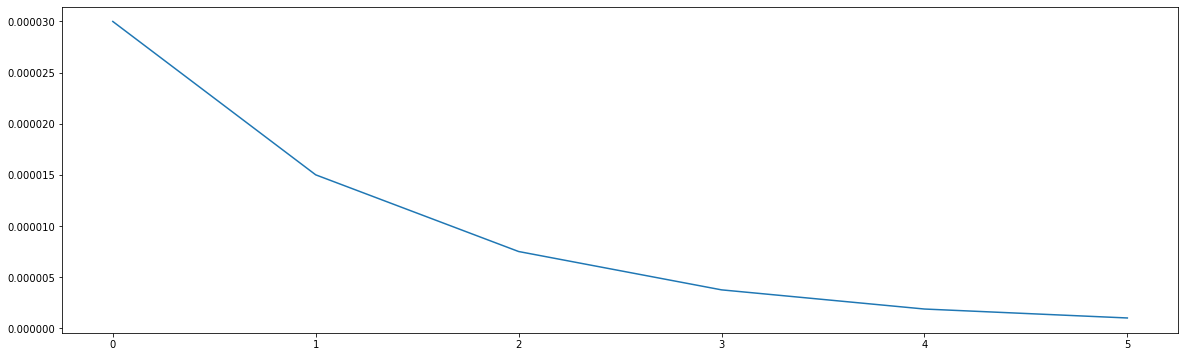

In [5]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
LR_EXP_DECAY = .5

@tf.function
def lrfn(epoch):
    lr = LR_MAX * LR_EXP_DECAY**epoch
    if lr < LR_MIN:
        lr = LR_MIN
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_start = layers.Dropout(.1)(last_hidden_state)
    x_start = layers.Dense(1)(x_start)
    x_start = layers.BatchNormalization()(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dropout(.1)(last_hidden_state)
    x_end = layers.Dense(1)(x_end)
    x_end = layers.BatchNormalization()(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)

    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    optimizer = optimizers.Adam(lr=config['LEARNING_RATE'])
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(label_smoothing=0.2),
                                   'y_end': losses.CategoricalCrossentropy(label_smoothing=0.2)}, 
                             metrics={'y_start': metrics.CategoricalAccuracy(),
                                      'y_end': metrics.CategoricalAccuracy()})
    
    return model

# Train

In [7]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    lr_schedule = LearningRateScheduler(lrfn)

    history = model.fit(list(x_train), list(y_train),
                        validation_data=(list(x_valid), list(y_valid)),
                        batch_size=config['BATCH_SIZE'], 
                        callbacks=[checkpoint, es, lr_schedule],
                        epochs=config['EPOCHS'], 
                        verbose=1).history
    history_list.append(history)
    model.save_weights('last_' + model_path)
    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train on 21984 samples, validate on 5496 samples
Epoch 1/6
21984/21984 [==============================] - 289s 13ms/sample - loss: 4.4546 - y_start_loss: 2.2032 - y_end_loss: 2.2514 - y_start_categorical_accuracy: 0.6559 - y_end_categorical_accuracy: 0.6450 - val_loss: 4.1558 - val_y_start_loss: 2.0755 - val_y_end_loss: 2.0799 - val_y_start_categorical_accuracy: 0.7125 - val_y_end_categorical_accuracy: 0.7213
Epoch 2/6
21984/21984 [==============================] - 274s 12ms/sample - loss: 3.9810 - y_start_loss: 2.0047 - y_end_loss: 1.9764 - y_start_categorical_accuracy: 0.7110 - y_end_categorical_accuracy: 0.7297 - val_loss: 3.9983 - val_y_start_loss: 2.0141 - val_y_end_loss: 1.9838 - val_y_start_categorical_accuracy: 0.7131 - val_y_end_categorical_accuracy: 0.7303
Epoch 3/6
21984/21984 [==============================] - 273s 12ms/sample - loss: 3.8669 - y_start_loss: 1.9532 - y_end_loss: 1.9136 - y_start_categorical_accuracy: 0.7303 - y_end_categorical_accuracy: 0.7548 - val

# Model loss graph

Fold: 1


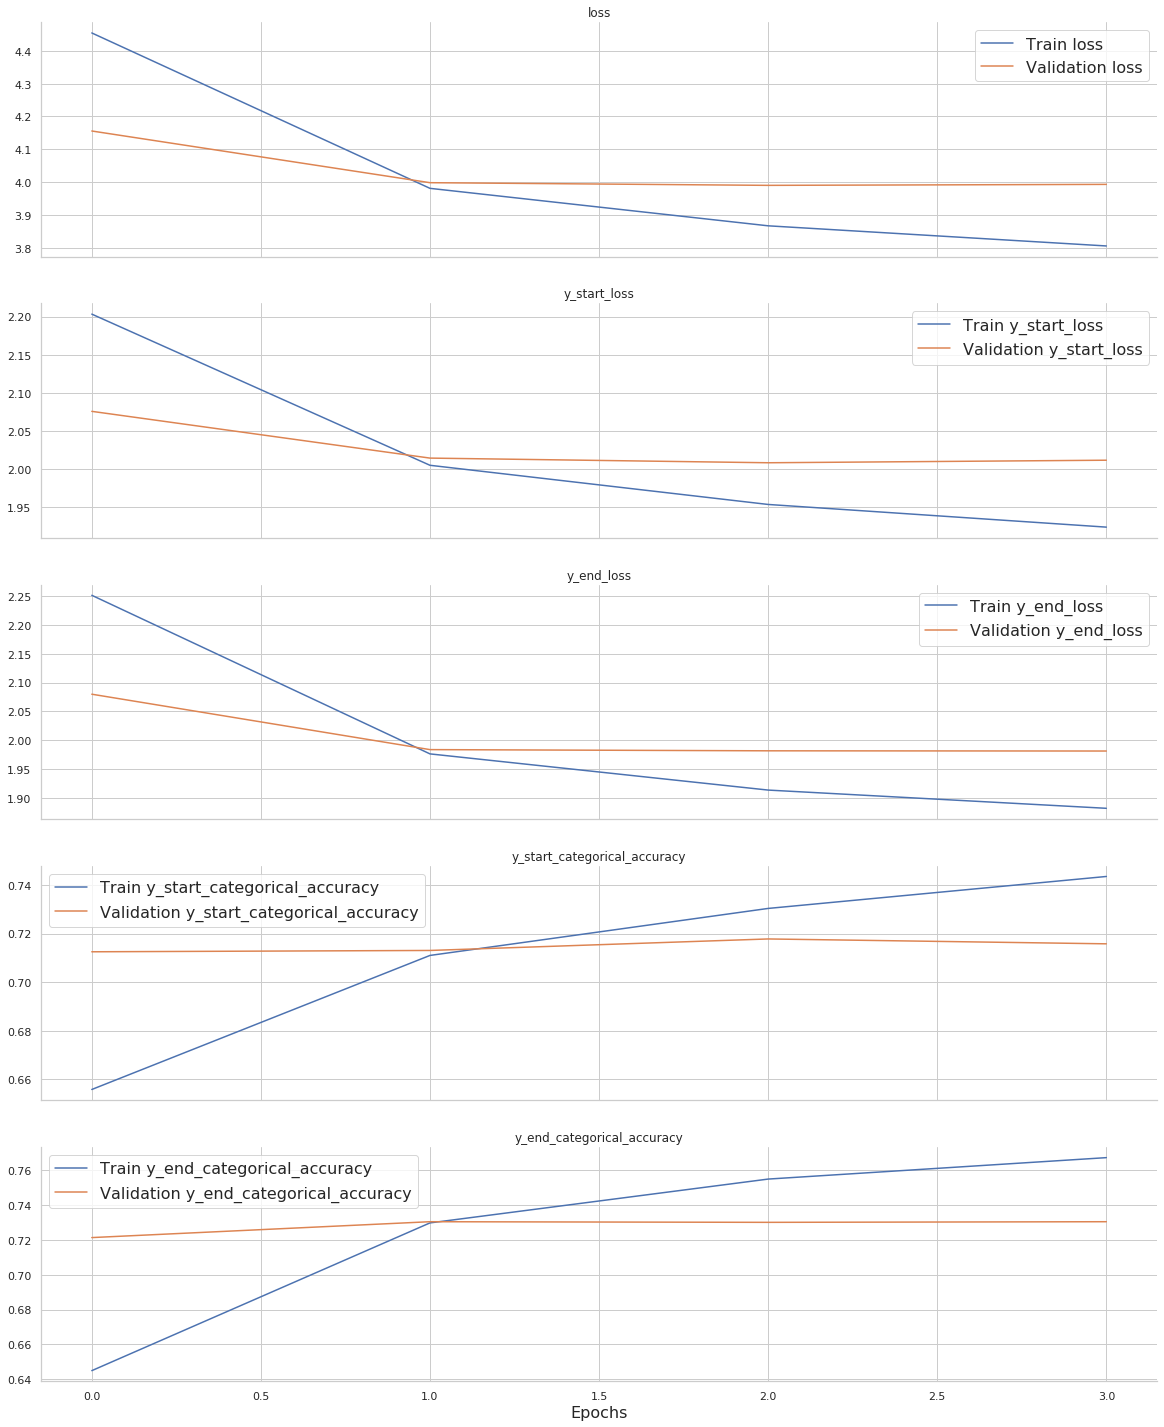

Fold: 2


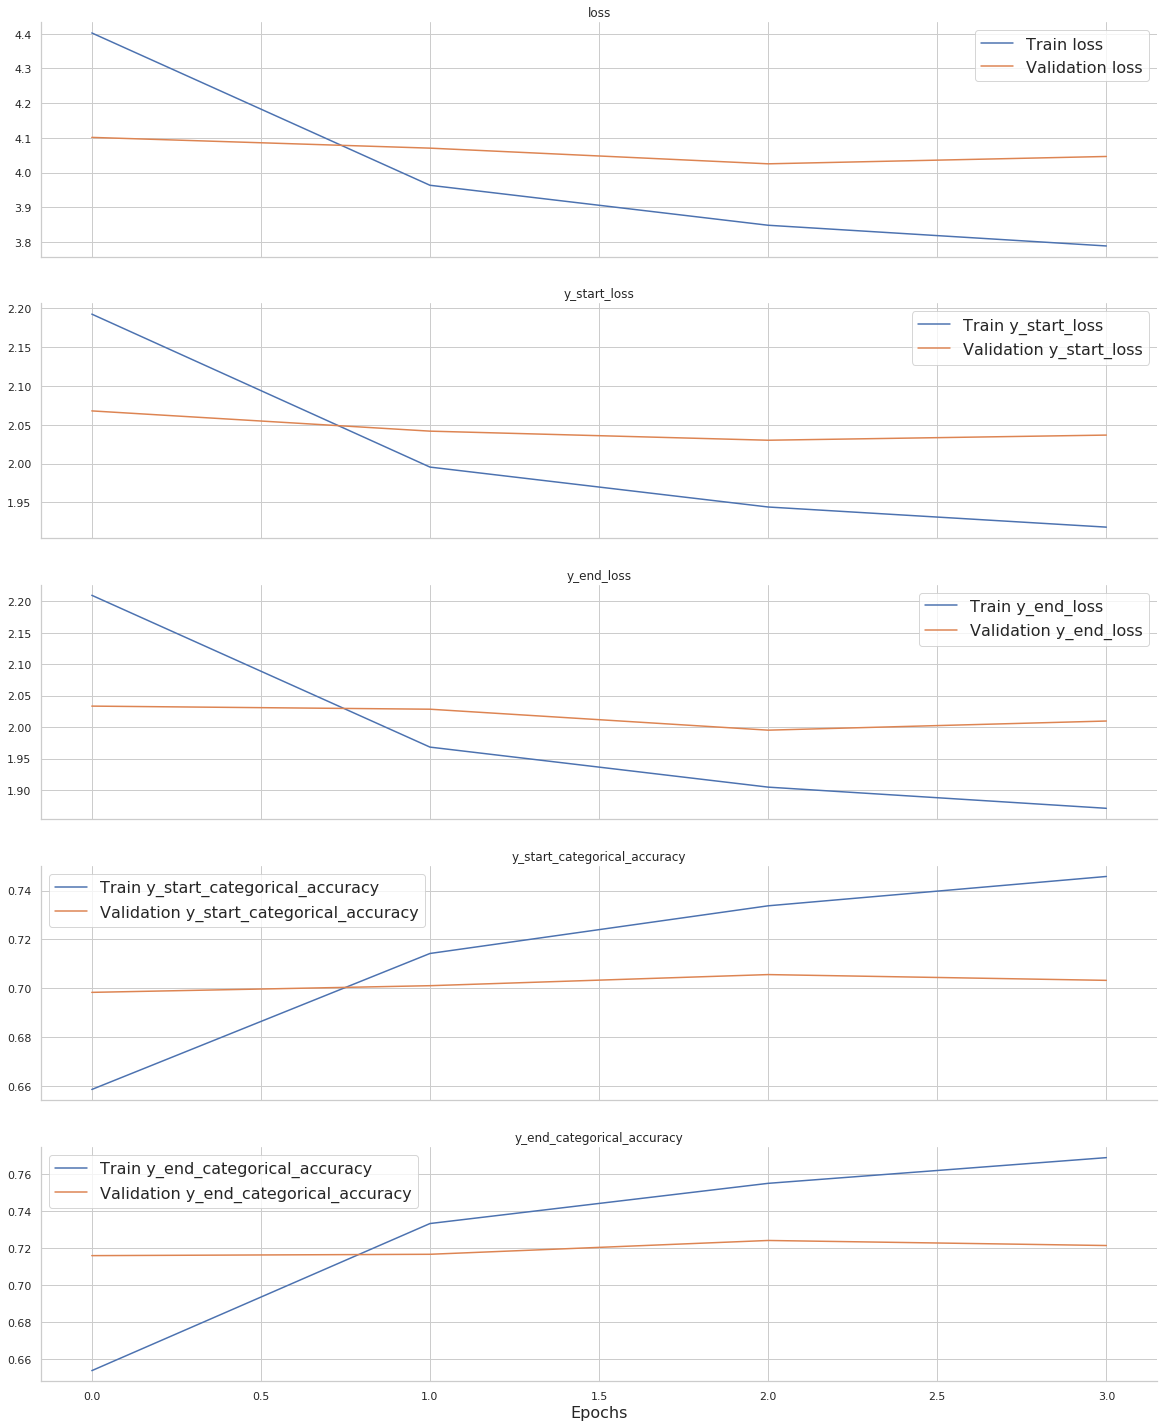

Fold: 3


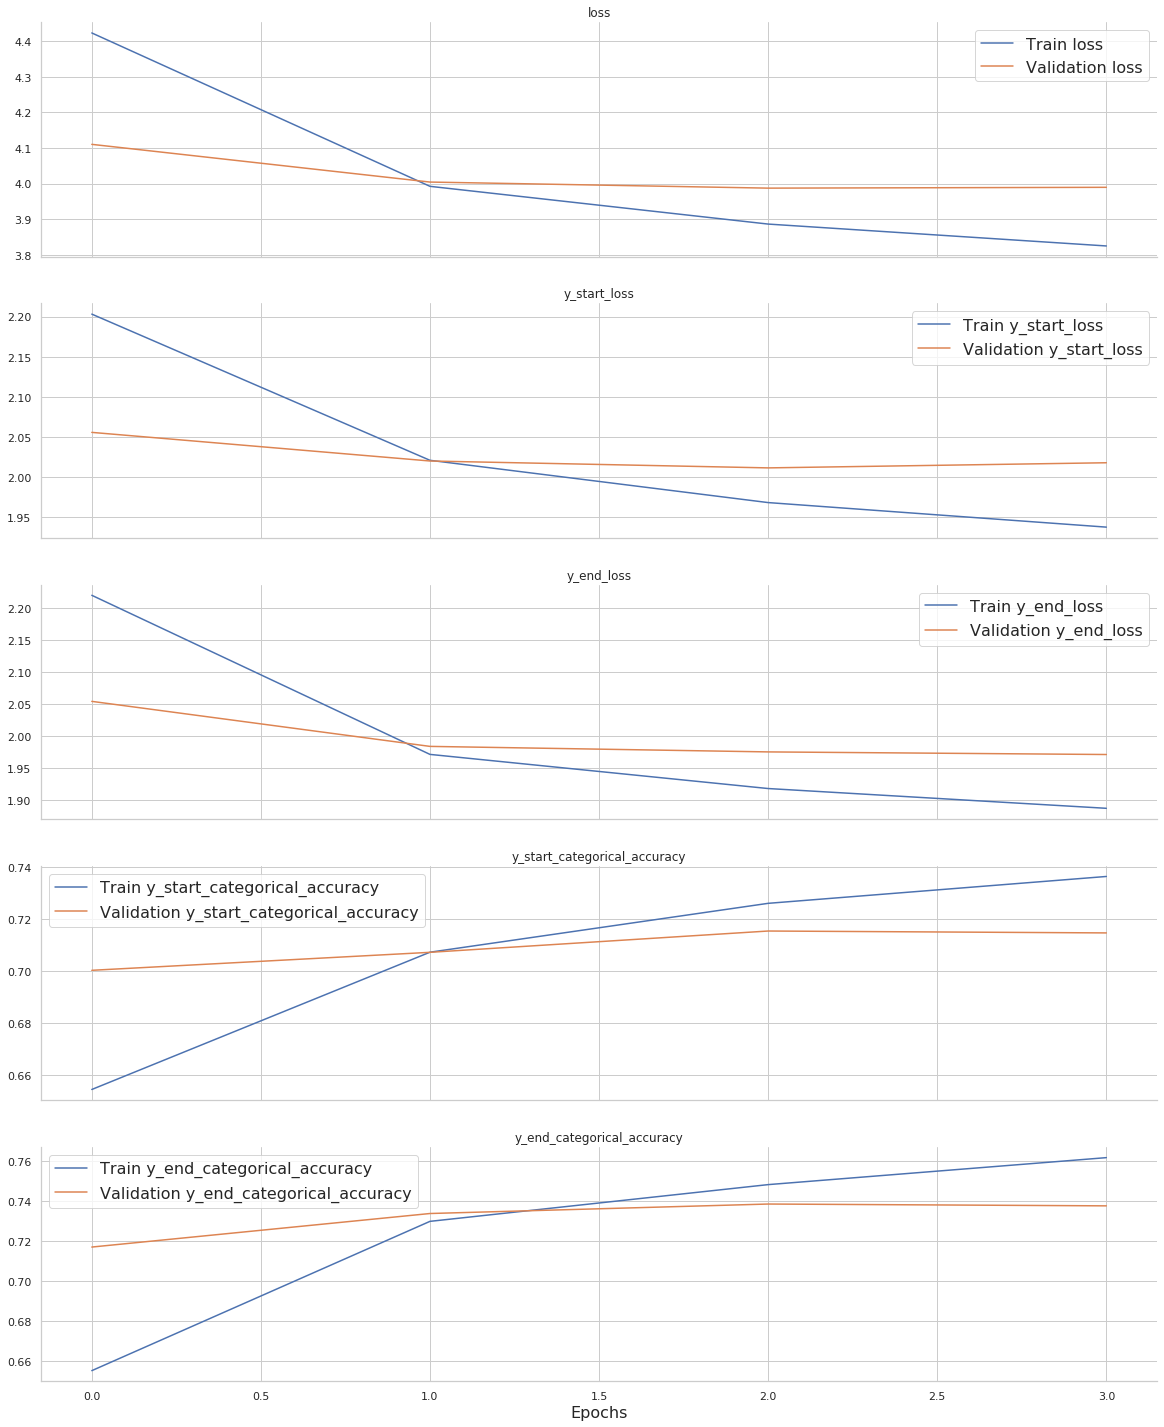

Fold: 4


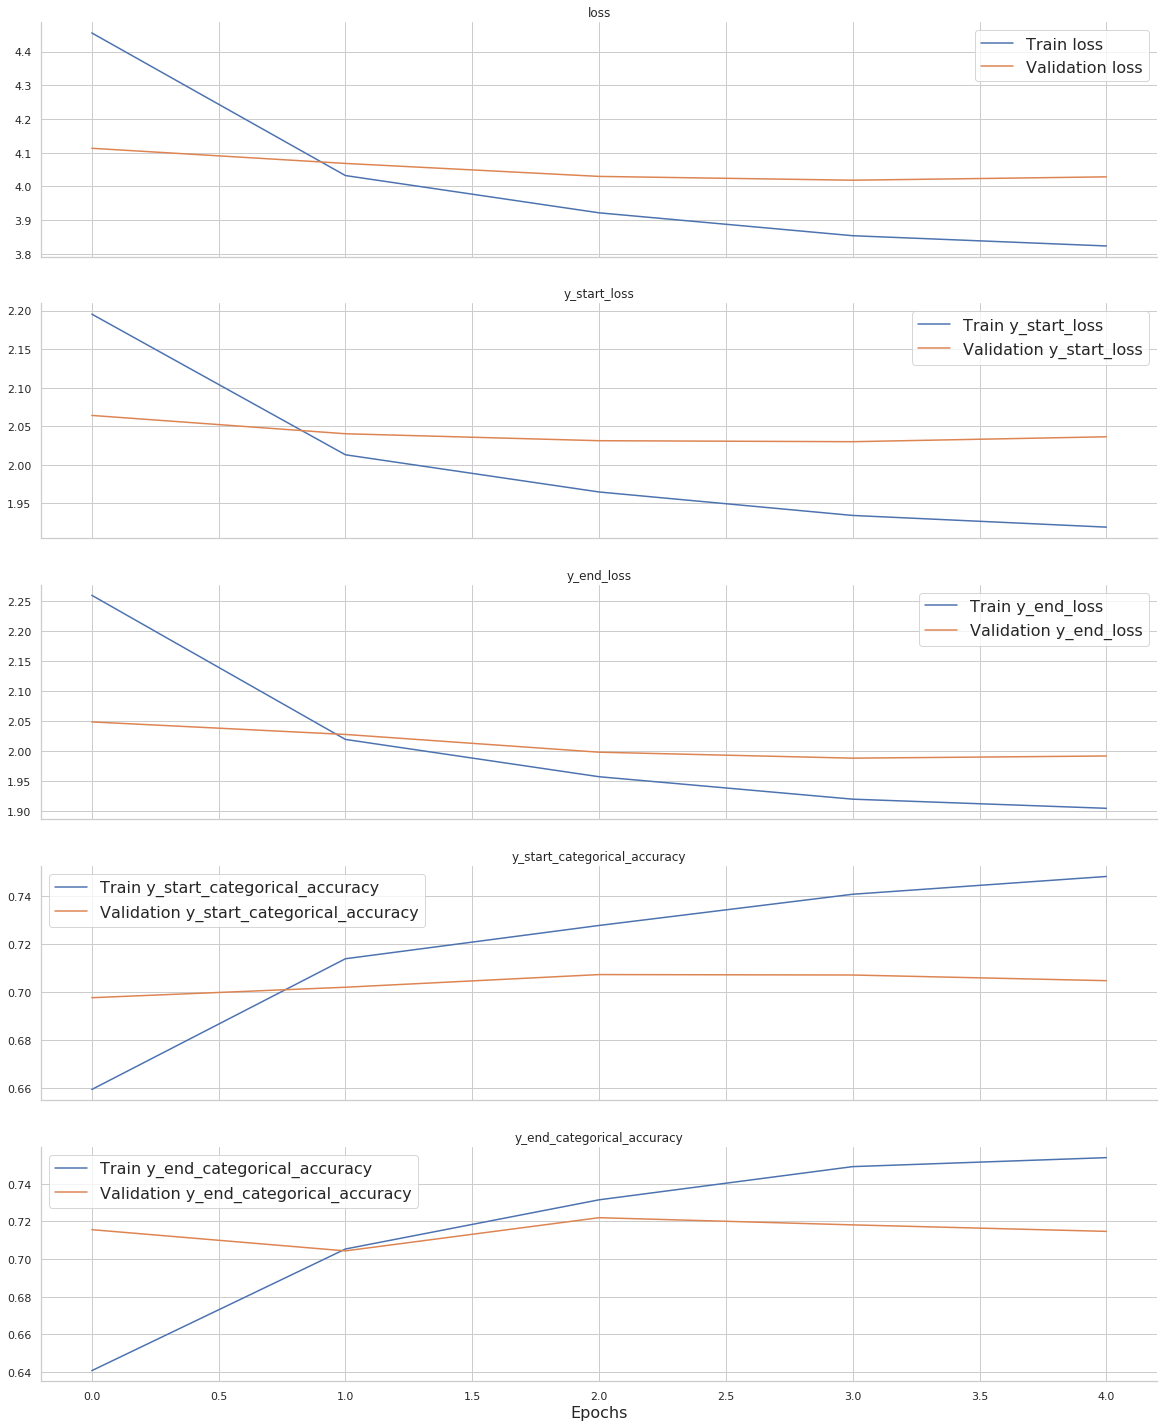

Fold: 5


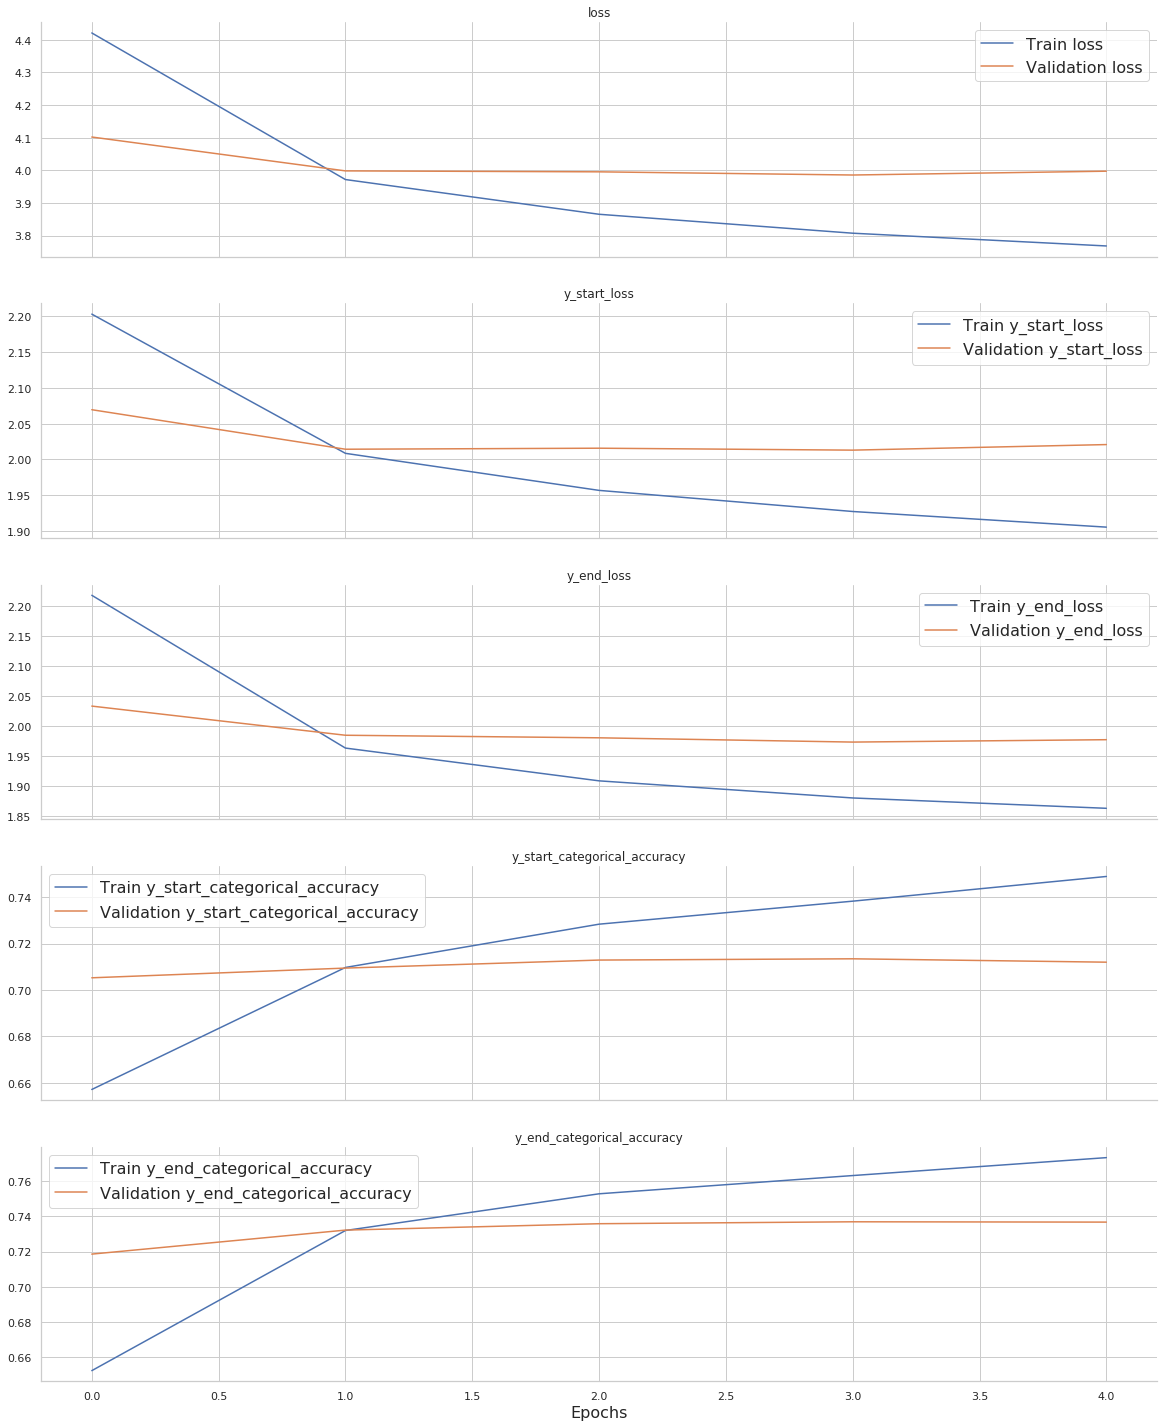

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.748189,0.705973,0.042216,0.750747,0.707060,0.751499,0.700037,0.740063,0.714319,0.745197,0.696832,0.753439,0.711616
Sentiment neutral,0.899040,0.884177,0.014863,0.974581,0.973908,0.974362,0.972963,0.973921,0.974501,0.598339,0.527171,0.973995,0.972341
Sentiment negative,0.602468,0.521304,0.081165,0.607750,0.519297,0.606084,0.512833,0.589293,0.533277,0.595923,0.510594,0.613292,0.530519
Sentiment positive,0.663389,0.617334,0.046055,0.590481,0.531470,0.594682,0.516064,0.573803,0.541532,0.963205,0.959434,0.594778,0.538172
0 <= text wordCnt < 3,0.864752,0.858831,0.005920,0.870921,0.839552,0.859159,0.873068,0.860679,0.871391,0.870909,0.833333,0.862089,0.876812
3 <= text wordCnt < 10,0.797509,0.766027,0.031482,0.799215,0.756238,0.798606,0.766871,0.788687,0.773655,0.801460,0.758125,0.799576,0.775246
10 <= text wordCnt < 30,0.717796,0.668901,0.048895,0.720957,0.675145,0.722160,0.660680,0.709259,0.679548,0.711199,0.658379,0.725408,0.670755
30 <= text wordCnt < 100,0.687844,0.599034,0.088810,0.676942,0.673761,0.723847,0.497871,0.708494,0.524078,0.671998,0.566180,0.657938,0.733278
0 <= selected text wordCnt < 3,0.693028,0.616383,0.076645,0.686434,0.601226,0.699136,0.610690,0.667624,0.611769,0.705487,0.616237,0.706457,0.641992


# Visualize predictions

In [10]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,sooo sad,1.000000,sooo sad,1.000000,sooo sad,1.000000,sad,0.500000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,"sons of ****,",1.000000,"sons of ****,",1.000000,"****,",0.333333,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,some shameless plugging for the best rangers f...,0.833333
6,2am feedings for the baby are fun when he is a...,fun,positive,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,wow...,0.200000,wow...,0.200000,wow... u just became cooler.,1.000000,wow...,0.200000,wow...,0.200000
